In [10]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns
import os
import pandas as pd
import scipy.optimize as opt
import statsmodels.formula.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.api import anova_lm
import matplotlib.cm as cm
# classification results
from sklearn.metrics import confusion_matrix, classification_report 

dump_dir = 'C:/Users/Bas/Google Drive/Bas Zahy Gianni - Games/Analysis/6_tur/Tur_yunqi (1)/'
fig_direc = 'C:/Users/Bas/Google Drive/Bas Zahy Gianni - Games/Manuscripts/Paper/Figures/'

In [11]:
# styling for figures
sns.set_style('white')
sns.set_context('paper')
sns.set_palette(sns.dark_palette('grey'))

matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.default'] = 'rm'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.major.size'] = 0
matplotlib.rcParams['ytick.major.size'] = 0

greens = sns.cubehelix_palette(n_colors=30, start=2.0, rot=.2, gamma=1, hue=.8, light=.8, dark=.15)
bayes_ci = .95
bmvs = lambda x: sts.bayes_mvs(x, alpha=bayes_ci)
%matplotlib inline

In [23]:
tur = pd.read_csv(dump_dir + 'turing_output.csv')
elo = pd.read_csv(dump_dir+'ratings_tur.csv')
vid = pd.read_csv(dump_dir + 'videoInfo.csv')

names = tur.user_name.unique()
tur['delta_c']=abs(tur['choice']-50)
tur = pd.merge(tur,pd.DataFrame(vid[['clip_id','start_pieces']]),on='clip_id')
tur = pd.merge(tur,pd.DataFrame(vid[['clip_id','wp_center']]),on='clip_id')
tur = pd.merge(tur,pd.DataFrame(vid[['clip_id','bp_center']]),on='clip_id')
tur = tur.sort_values(by='timestamp')
tur['human'] = (tur['choice']>=50).astype(int)
tur = pd.merge(tur,elo,on='user_name')

In [24]:
# understand the video statistics
vid_0 = vid.loc[vid['clip_type']==0]
vid_1 = vid.loc[vid['clip_type']==1]
print(len(vid_0))
print(len(vid_1))

90
90


### About videos
#### 1. Generally we see that computer videos actually start at the center a little more often... contrary to what we might expect
#### 2. start pieces are equal across computer or humans videos
#### 3. human videos are on average longer than computer videos

In [177]:
print(vid_0.start_pieces.mean())
print(vid_1.start_pieces.mean())
print(np.mean(vid_0.length),np.std(vid_0.length)/np.sqrt(np.prod(vid_0.length.shape)))
print(np.mean(vid_1.length),np.std(vid_1.length)/np.sqrt(np.prod(vid_1.length.shape)))
print(sts.ttest_ind(vid_0.length,vid_1.length))

6.8
6.3
8.022222222222222 0.607154418859
10.733333333333333 0.687776880272
Ttest_indResult(statistic=-2.9386592595518439, pvalue=0.0037332413302826012)


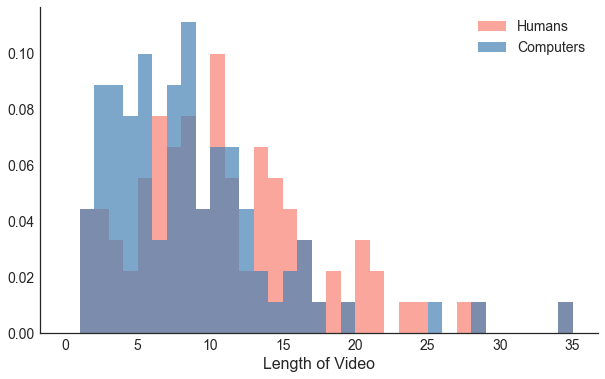

In [172]:
# Histogram of number of each length video
f, ax = plt.subplots(1, 1, figsize=(10,6))

ax.hist(vid_1.length, bins=np.arange(0, 36, 1), alpha=.7, normed=True, color='salmon', label='Humans')
ax.hist(vid_0.length, bins=np.arange(0, 36, 1), alpha=.7, normed=True, color='steelblue', label='Computers')
ax.legend(loc='upper right')

plt.xlabel("Length of Video")

sns.despine()
f.savefig(fig_direc + 'turing_video_length.pdf')

In [86]:
# average percent correct: 55.35%
print(sts.bayes_mvs(tur.feedback, alpha=.95))

#for i in range(0,30):
#    print sts.bayes_mvs(tur.loc[tur.user_name==names[i], 'feedback'].values.astype(int))
#    print('\n')


(Mean(statistic=0.55351851851851852, minmax=(0.54025926684582459, 0.56677777019121245)), Variance(statistic=0.24713576817558297, minmax=(0.23781392452066813, 0.25645761183049781)), Std_dev(statistic=0.4971275170170959, minmax=(0.48775181024587499, 0.5065032237883168)))


### 1. Does people’s confidence reflect their accuracy in distinguishing the video types? 
#### need: average by subject for cross subject analysis
#### average by subject and length for within subject
#### average by subject and type for within subject
### 2. Is there anything that makes some puzzles easier to identify? or more confident in identifying??
#### (elo)
#### average by video ID
#### average by length (need to address AGGREGATION issues)
#### average by type
### 3. What affects report as human (binary, logistic)
### 4. What affects confidence (logistic, ANOVA)
#### use all data in tur

In [35]:
## 1. Does people’s confidence reflect their accuracy in distinguishing the video types? 
### need: average by subject for cross subject analysis
tur_sub = tur.groupby([tur.user_name]).mean().reset_index()
tur_l = tur.groupby([tur.length]).mean().reset_index()
tur_t = tur.groupby([tur.clip_type]).mean().reset_index()

tur_sl = tur.groupby([tur.user_name,tur.length]).mean().reset_index()
tur_st = tur.groupby([tur.user_name,tur.clip_type]).mean().reset_index()
tur_vid = tur.groupby([tur.clip_id]).mean().reset_index()
tur_vid2 = tur.groupby([tur.clip_id]).max().reset_index()
tur_vid['pred_weighted'] = tur_vid.human * (tur_vid.delta_c/max(tur_vid2.delta_c))


In [38]:
# the unique values of video length: 1 - 35
length = tur_sl.loc[tur_sl.user_name==names[28], 'length'].values.astype(int) 
length

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 23, 24, 25, 27, 28, 34, 35])

In [39]:
start_pieces = tur_sl.loc[tur_sl.user_name==names[28], 'length'].values.astype(int) 

In [40]:
tur_sub.corr(method='pearson', min_periods=1)                        # check names order
#tur_l.corr(method='spearman', min_periods=1)

,clip_id,length,choice,feedback,timestamp,clip_type,delta_c,start_pieces,wp_center,bp_center,human,elo
clip_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
length,NaN,1.000000e+00,-1.160768e-15,3.793215e-17,6.835615e-14,NaN,9.607094e-17,1.000000e+00,-1.000000e+00,NaN,-1.515076e-15,2.820312e-17
choice,NaN,-1.160768e-15,1.000000e+00,-2.880405e-01,-1.751378e-02,NaN,2.965840e-01,-1.160768e-15,1.160768e-15,NaN,8.214062e-01,1.473996e-01
feedback,NaN,3.793215e-17,-2.880405e-01,1.000000e+00,-1.698506e-01,NaN,1.506209e-01,3.793215e-17,-3.793215e-17,NaN,-2.223527e-01,1.876086e-01
timestamp,NaN,6.835615e-14,-1.751378e-02,-1.698506e-01,1.000000e+00,NaN,-2.028293e-02,6.835615e-14,-6.835615e-14,NaN,-1.260674e-01,5.540154e-02
clip_type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
delta_c,NaN,9.607094e-17,2.965840e-01,1.506209e-01,-2.028293e-02,NaN,1.000000e+00,1.143702e-16,-1.143702e-16,NaN,2.407311e-01,1.780882e-01
start_pieces,NaN,1.000000e+00,-1.160768e-15,3.793215e-17,6.835615e-14,NaN,1.143702e-16,1.000000e+00,-1.000000e+00,NaN,-1.481408e-15,0.000000e+00
wp_center,NaN,-1.000000e+00,1.160768e-15,-3.793215e-17,-6.835615e-14,NaN,-1.143702e-16,-1.000000e+00,1.000000e+00,NaN,1.481408e-15,0.000000e+00
bp_center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
tur_l.corr(method='pearson', min_periods=1)
#tur_l.corr(method='spearman', min_periods=1)

,length,clip_id,choice,feedback,timestamp,clip_type,delta_c,start_pieces,wp_center,bp_center,human,elo
length,1.000000,0.127182,0.788214,0.168791,0.569871,0.310249,0.788671,-0.245630,-0.195426,-0.196692,0.679927,NaN
clip_id,0.127182,1.000000,0.190127,0.156572,0.254539,0.240077,0.185072,-0.150029,-0.409775,-0.328251,0.163959,NaN
choice,0.788214,0.190127,1.000000,0.446055,0.572017,0.521044,0.535816,-0.069813,-0.131214,-0.110222,0.948677,NaN
feedback,0.168791,0.156572,0.446055,1.000000,0.075977,0.705066,0.258888,-0.396543,-0.369252,-0.402610,0.515501,NaN
timestamp,0.569871,0.254539,0.572017,0.075977,1.000000,0.053353,0.400921,-0.035209,-0.219701,-0.270854,0.492685,NaN
clip_type,0.310249,0.240077,0.521044,0.705066,0.053353,1.000000,0.364630,-0.460728,-0.433554,-0.223815,0.494794,NaN
delta_c,0.788671,0.185072,0.535816,0.258888,0.400921,0.364630,1.000000,-0.256756,-0.270075,-0.258978,0.356740,NaN
start_pieces,-0.245630,-0.150029,-0.069813,-0.396543,-0.035209,-0.460728,-0.256756,1.000000,0.783954,0.544243,-0.086668,NaN
wp_center,-0.195426,-0.409775,-0.131214,-0.369252,-0.219701,-0.433554,-0.270075,0.783954,1.000000,0.657519,-0.135774,NaN
bp_center,-0.196692,-0.328251,-0.110222,-0.402610,-0.270854,-0.223815,-0.258978,0.544243,0.657519,1.000000,-0.125783,NaN


In [42]:
tur_sl.corr(method='pearson', min_periods=1)
#tur_st.corr(method='spearman', min_periods=1)

,length,clip_id,choice,feedback,timestamp,clip_type,delta_c,start_pieces,wp_center,bp_center,human,elo
length,1.000000e+00,1.271820e-01,0.334066,0.077358,0.000028,3.102495e-01,0.182543,-2.456301e-01,-1.954256e-01,-1.966921e-01,0.281369,-9.527999e-18
clip_id,1.271820e-01,1.000000e+00,0.080581,0.071758,0.000012,2.400774e-01,0.042836,-1.500288e-01,-4.097752e-01,-3.282512e-01,0.067850,-1.969890e-18
choice,3.340659e-01,8.058108e-02,1.000000,0.301726,-0.028862,2.208322e-01,0.237341,-2.958845e-02,-5.561208e-02,-4.671503e-02,0.867498,2.834541e-02
feedback,7.735755e-02,7.175752e-02,0.301726,1.000000,-0.057518,3.231351e-01,0.074638,-1.817375e-01,-1.692300e-01,-1.845179e-01,0.334802,1.465374e-02
timestamp,2.777852e-05,1.240756e-05,-0.028862,-0.057518,1.000000,2.600717e-06,0.023832,-1.716265e-06,-1.070938e-05,-1.320285e-05,-0.048462,5.540563e-02
clip_type,3.102495e-01,2.400774e-01,0.220832,0.323135,0.000003,1.000000e+00,0.084396,-4.607285e-01,-4.335537e-01,-2.238152e-01,0.204757,-2.539675e-18
delta_c,1.825429e-01,4.283601e-02,0.237341,0.074638,0.023832,8.439599e-02,1.000000,-5.942782e-02,-6.251052e-02,-5.994223e-02,0.114900,1.581893e-01
start_pieces,-2.456301e-01,-1.500288e-01,-0.029588,-0.181737,-0.000002,-4.607285e-01,-0.059428,1.000000e+00,7.839543e-01,5.442431e-01,-0.035865,-7.356371e-18
wp_center,-1.954256e-01,-4.097752e-01,-0.055612,-0.169230,-0.000011,-4.335537e-01,-0.062511,7.839543e-01,1.000000e+00,6.575186e-01,-0.056186,-6.970382e-18
bp_center,-1.966921e-01,-3.282512e-01,-0.046715,-0.184518,-0.000013,-2.238152e-01,-0.059942,5.442431e-01,6.575186e-01,1.000000e+00,-0.052052,-1.656583e-18


In [43]:
tur_st.corr(method='pearson', min_periods=1)
#tur_st.corr(method='spearman', min_periods=1)

,clip_type,clip_id,length,choice,feedback,timestamp,delta_c,start_pieces,wp_center,bp_center,human,elo
clip_type,1.000000,1.000000,1.000000,0.550361,0.172001,-0.000008,-0.021564,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.519486,0.000000e+00
clip_id,1.000000,1.000000,1.000000,0.550361,0.172001,-0.000008,-0.021564,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.519486,0.000000e+00
length,1.000000,1.000000,1.000000,0.550361,0.172001,-0.000008,-0.021564,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.519486,0.000000e+00
choice,0.550361,0.550361,0.550361,1.000000,-0.025471,-0.011912,0.158203,-5.503613e-01,-5.503613e-01,-5.503613e-01,0.879009,1.002174e-01
feedback,0.172001,0.172001,0.172001,-0.025471,1.000000,-0.092719,0.114751,-1.720012e-01,-1.720012e-01,-1.720012e-01,-0.083318,1.024122e-01
timestamp,-0.000008,-0.000008,-0.000008,-0.011912,-0.092719,1.000000,-0.020099,8.062151e-06,8.062151e-06,8.062151e-06,-0.089674,5.540154e-02
delta_c,-0.021564,-0.021564,-0.021564,0.158203,0.114751,-0.020099,1.000000,2.156361e-02,2.156361e-02,2.156361e-02,0.128632,1.764645e-01
start_pieces,-1.000000,-1.000000,-1.000000,-0.550361,-0.172001,0.000008,0.021564,1.000000e+00,1.000000e+00,1.000000e+00,-0.519486,7.050780e-18
wp_center,-1.000000,-1.000000,-1.000000,-0.550361,-0.172001,0.000008,0.021564,1.000000e+00,1.000000e+00,1.000000e+00,-0.519486,-6.610106e-18
bp_center,-1.000000,-1.000000,-1.000000,-0.550361,-0.172001,0.000008,0.021564,1.000000e+00,1.000000e+00,1.000000e+00,-0.519486,-9.915159e-18


In [44]:
tur_vid.corr(method='pearson', min_periods=1)
#tur_st.corr(method='spearman', min_periods=1)

,clip_id,length,choice,feedback,timestamp,clip_type,delta_c,start_pieces,wp_center,bp_center,human,elo,pred_weighted
clip_id,1.000000,7.145554e-02,4.676275e-02,1.463297e-01,1.034733e-01,0.010264,-6.057029e-02,-0.094811,-4.004202e-02,-7.571583e-02,7.660273e-02,0.000000e+00,3.969242e-02
length,0.071456,1.000000e+00,4.490696e-01,1.442103e-01,1.337819e-01,0.174984,4.546217e-01,-0.133350,-5.090385e-02,-8.871620e-02,3.719010e-01,4.345632e-17,5.951754e-01
choice,0.046763,4.490696e-01,1.000000e+00,-5.126447e-02,2.280077e-02,0.388970,-1.572505e-01,0.112464,8.988423e-03,5.409952e-02,9.464802e-01,-2.597055e-16,8.793192e-01
feedback,0.146330,1.442103e-01,-5.126447e-02,1.000000e+00,1.374647e-02,0.102357,2.593970e-01,-0.164066,-1.840077e-01,-1.752349e-01,-2.960135e-02,8.762529e-17,8.042156e-02
timestamp,0.103473,1.337819e-01,2.280077e-02,1.374647e-02,1.000000e+00,-0.137613,7.800652e-02,-0.020145,2.214657e-03,6.293352e-02,-2.436885e-02,9.387836e-11,1.875437e-02
clip_type,0.010264,1.749837e-01,3.889699e-01,1.023569e-01,-1.376132e-01,1.000000,-5.635718e-02,-0.051016,-3.794430e-02,-5.445328e-02,3.372867e-01,0.000000e+00,3.290448e-01
delta_c,-0.060570,4.546217e-01,-1.572505e-01,2.593970e-01,7.800652e-02,-0.056357,1.000000e+00,-0.126172,-5.185104e-03,-9.840846e-02,-2.290717e-01,-3.017136e-16,2.546028e-01
start_pieces,-0.094811,-1.333498e-01,1.124638e-01,-1.640664e-01,-2.014466e-02,-0.051016,-1.261717e-01,1.000000,5.261411e-01,4.330882e-01,1.332144e-01,0.000000e+00,9.275415e-02
wp_center,-0.040042,-5.090385e-02,8.988423e-03,-1.840077e-01,2.214657e-03,-0.037944,-5.185104e-03,0.526141,1.000000e+00,4.673036e-01,-1.415615e-02,-2.606234e-16,9.566230e-03
bp_center,-0.075716,-8.871620e-02,5.409952e-02,-1.752349e-01,6.293352e-02,-0.054453,-9.840846e-02,0.433088,4.673036e-01,1.000000e+00,3.581124e-02,9.834059e-17,9.586450e-03


In [45]:
pieces = tur.sort_values(by='start_pieces').start_pieces.unique()
len(pieces)

22

In [46]:
# added characteristic of starting pieces? do they take into account of that?
tur_pieces = tur.groupby(['start_pieces']).mean().reset_index()
tur_sp = tur.groupby(['user_name','start_pieces']).mean().reset_index()

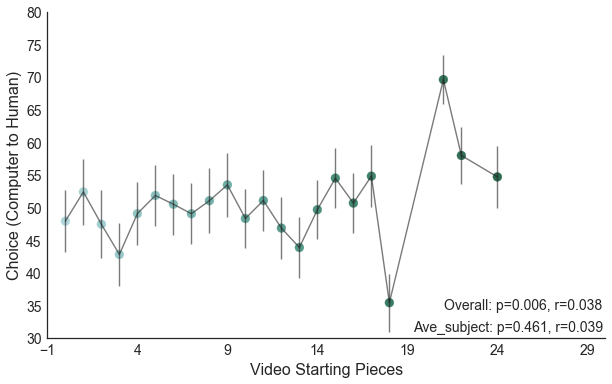

In [47]:
# Bias as a function of vid starting pieces?
fig, axes = plt.subplots(1, 1, figsize=(10,6))

tur_pie = dict()
for i in range(0,22,1):
    tur_pie[i] = tur.loc[tur.start_pieces==pieces[i]]
y = [np.mean(tur_pie[i]['choice']) for i in range(0,22,1)]
yerr = [np.std(tur_pie[i]['choice'])/np.sqrt(30) for i in range(0,22,1)]
axes.errorbar(pieces, y, yerr,alpha=0.6)

# averaging correlations for each subject
tur_subject = dict()
r_values=[]
p_values=[]
r_pearson = []
for i in range(0,30,1):
    tur_subject[i] = tur.loc[tur.user_name == names[i]]
    slope, intercept, r_val, p_val, std_err = sts.linregress(tur_subject[i].choice, tur_subject[i].start_pieces)
    r_values.append(r_val)
    p_values.append(p_val)
    r_pearson.append(np.corrcoef(tur_subject[i].start_pieces, tur_subject[i].choice)[0, 1])
# average over within subject correlations
r_mean = np.average(r_values)
p_mean = np.average(p_values)
r_pmean = np.average(r_pearson)

# huge correlation using all trials
slope, intercept, r_value, p_value, std_err = sts.linregress(tur.start_pieces, tur.choice)

if (p_value<0.001):
    text_1 = 'Overall: p<0.001, '+'r='+str(round(r_value,3))
else:
    text_1 = 'Overall: p='+str(round(p_value,3))+', '+'r='+str(round(r_value,3))
if (p_mean<0.001):
    text_2 = 'Ave_subject: p<0.001, '+'r='+str(round(r_mean,3))
else:
    text_2 = 'Ave_subject: p='+str(round(p_mean,3))+', '+'r='+str(round(r_mean,3))
plt.figtext(0.785,0.20,text_1, fontsize=14, ha='center', va='center', transform=axes.transAxes)
plt.figtext(0.765,0.15,text_2, fontsize=14, ha='center', va='center', transform=axes.transAxes)
if (round(r_pmean,2)!=round(r_mean,2)):
    plt.figtext(0.75,0.25,'Pearson: r='+str(round(r_mean,3)), fontsize=14, ha='center', va='center', transform=axes.transAxes)

plt.setp(
    axes, 
    xlim=[-1, 30], xticks=np.arange(-1, 31, 5), xlabel='Video Starting Pieces',
    ylim=[30,80], yticks=np.arange(30, 81, 5), ylabel='Choice (Computer to Human)'
)

plt.scatter(tur_pieces.start_pieces, tur_pieces.choice,s=80,color=greens)

sns.despine()

### Qn 0: Is there bias towards an answer?
#### 16 subjects' mean choice is towards "people play", 14 towards "computer", no systematic bias

In [48]:
print(len(tur_vid.loc[tur_vid['choice']>=50]))

82


0.0371462018086 0.150809763712 7.70915925328e-29


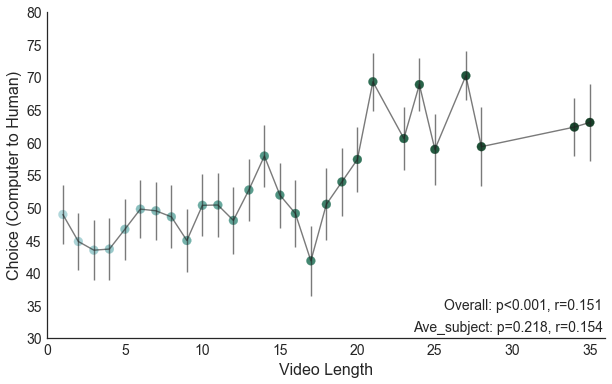

In [60]:
# Bias as a function of vid length??
fig, axes = plt.subplots(1, 1, figsize=(10,6))

tur_len = dict()
for i,l in enumerate(length):
    tur_len[i] = tur.loc[tur.length==l]
y = [np.mean(tur_len[i]['choice']) for i in range(0,28,1)]
yerr = [np.std(tur_len[i]['choice'])/np.sqrt(30) for i in range(0,28,1)]
axes.errorbar(length, y, yerr,alpha=0.6)

# averaging correlations for each subject
tur_subject = dict()
r_values=[]
p_values=[]
r_pearson = []
for i in range(0,30,1):
    tur_subject[i] = tur.loc[tur.user_name == names[i]]
    slope, intercept, r_val, p_val, std_err = sts.linregress(tur_subject[i].choice, tur_subject[i].length)
    r_values.append(r_val)
    p_values.append(p_val)
    r_pearson.append(np.corrcoef(tur_subject[i].length, tur_subject[i].choice)[0, 1])
# average over within subject correlations
r_mean = np.average(r_values)
p_mean = np.average(p_values)
r_pmean = np.average(r_pearson)

slope, intercept, r_value, p_value, std_err = sts.linregress(tur.choice, tur.length)
print(slope,r_value,p_value)

plt.scatter(tur_l.length, tur_l.choice,s=80,color=greens)

if (p_value<0.001):
    text_1 = 'Overall: p<0.001, '+'r='+str(round(r_value,3))
else:
    text_1 = 'Overall: p='+str(round(p_value,3))+', '+'r='+str(round(r_value,3))
if (p_mean<0.001):
    text_2 = 'Ave_subject: p<0.001, '+'r='+str(round(r_mean,3))
else:
    text_2 = 'Ave_subject: p='+str(round(p_mean,3))+', '+'r='+str(round(r_mean,3))
plt.figtext(0.785,0.20,text_1, fontsize=14, ha='center', va='center', transform=axes.transAxes)
plt.figtext(0.765,0.15,text_2, fontsize=14, ha='center', va='center', transform=axes.transAxes)
if (round(r_pmean,2)!=round(r_mean,2)):
    plt.figtext(0.75,0.25,'Pearson: r='+str(round(r_mean,3)), fontsize=14, ha='center', va='center', transform=axes.transAxes)

plt.setp(
    axes, 
    xlim=[0, 36], xticks=np.arange(0, 36, 5), xlabel='Video Length',
    ylim=[30,80], yticks=np.arange(30, 81, 5), ylabel='Choice (Computer to Human)'
)
sns.despine()
fig.savefig(fig_direc + 'bias_length.pdf')

### no discrimination as a function of initial board number of pieces

In [ ]:
# there are actually 7 human videos and only 4 computer videos when the video has length over 20
# tur_subject[0].loc[tur_subject[0].length>20].sort_values(by='length')

In [61]:
tur_st = tur_st.sort_values(by=['user_name','clip_type'])

0.00245974182181 0.130626643988 5.51688016626e-22


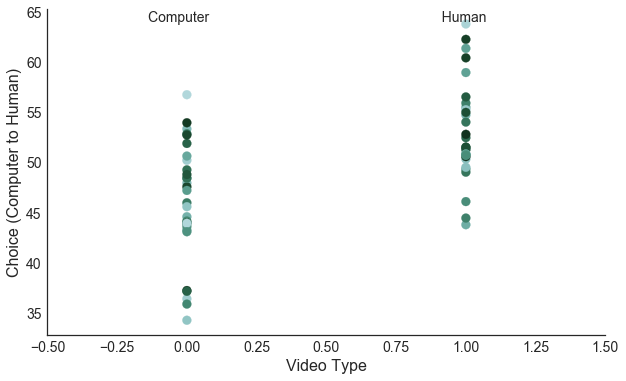

In [62]:
# Bias as a function of vid type?
fig, axes = plt.subplots(1, 1, figsize=(10,6))

plt.scatter(tur_st.clip_type, tur_st.choice,s=80,color=greens)

slope, intercept, r_value, p_value, std_err = sts.linregress(tur.choice, tur.clip_type)
print(slope,r_value,p_value)


#axes.set_ylim([30,80])
axes.set_xlim([-0.5,1.5])

plt.setp(
    axes, 
    ylabel='Choice (Computer to Human)', xlabel='Video Type'
)

text = 'Computer                                                            Human'
plt.figtext(0.5,0.86,text, fontsize=14, ha='center', va='center', transform=axes.transAxes)

sns.despine()

### Question 2. Is there anything that makes some puzzles easier to identify? or more confident in identifying??
#### average by video ID

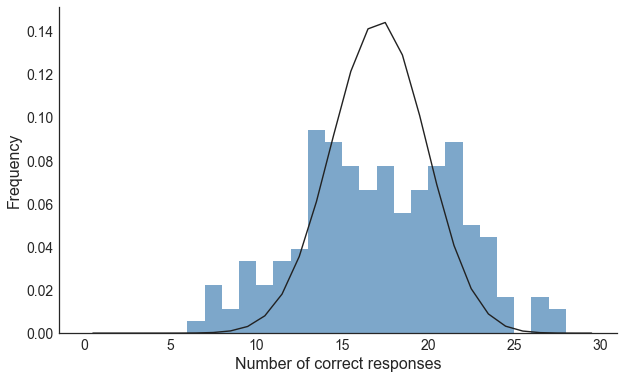

In [88]:
# Histogram of number of correct response                                                     # check why failed
# 30 subjects, p=0.55
# test for number of successes, if independently drawn, follows the binomial distribution
fig, axes = plt.subplots(1, 1, figsize=(10,6))

# binomial
x = np.arange(0,30,1)
y =  sts.binom.pmf(x,30,0.55351851851851852)
plt.plot(x+0.5,y)

# histogram of percentage correct
n = plt.hist(tur_vid.feedback*30, bins=x, alpha=.7, normed=True, color='steelblue')

plt.setp(
    axes, 
    ylabel='Frequency', xlabel='Number of correct responses'
)

sns.despine()
fig.savefig(fig_direc + '')

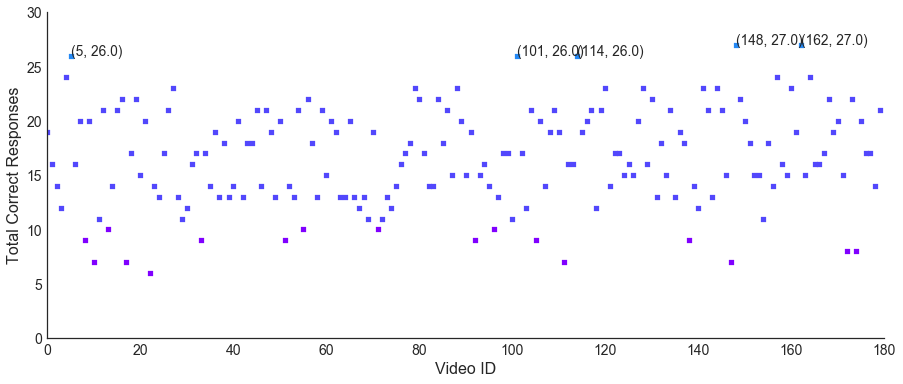

In [89]:
fig, axes = plt.subplots(1, 1, figsize=(15,6))
colors = iter(cm.rainbow(np.linspace(0, 1, 12)))

#plt.scatter(tur_vid.clip_id, tur_vid.feedback*30,alpha=1,marker='s',s=20,color="steelblue")
tur_vid_low = tur_vid.loc[tur_vid.feedback*30<=10]
tur_vid_mid = tur_vid.loc[tur_vid.feedback*30<=25]
tur_vid_mid = tur_vid_mid.loc[tur_vid_mid.feedback*30>=11]
tur_vid_high = tur_vid.loc[tur_vid.feedback*30>=26]
plt.scatter(tur_vid_low.clip_id, tur_vid_low.feedback*30,alpha=1,marker='s',s=25,color=next(colors))
plt.scatter(tur_vid_mid.clip_id, tur_vid_mid.feedback*30,alpha=1,marker='s',s=25,color=next(colors))
plt.scatter(tur_vid_high.clip_id, tur_vid_high.feedback*30,alpha=1,marker='s',s=25,color=next(colors))

for xy in zip(tur_vid_high.clip_id, tur_vid_high.feedback*30):                                       # <--
    axes.annotate('(%s, %s)' % xy, xy=xy, size=13.8, textcoords='data')

plt.setp(
    axes, 
    ylabel='Total Correct Responses', xlabel='Video ID'
)

axes.set_xlim([0,180])
axes.set_ylim([0,30])

sns.despine()

In [67]:
tur_vid2 = tur_vid2.sort_values(by=['feedback','clip_id'],ascending=False)
high = tur_vid2.loc[tur_vid2.feedback>=25]
tur_vid2.head(6) #5 out of 180 videos are correctly identified more than 24 times out of 30s (80%)

,clip_id,user_name,length,choice,feedback,timestamp,clip_type,delta_c,start_pieces,wp_center,bp_center,human,elo
179,179,TW,4,100,1,1487288593864,0,50,1,0,1,1,250
178,178,TW,3,98,1,1487286045990,0,48,3,0,1,1,250
177,177,TW,10,96,1,1487288498136,0,50,0,0,0,1,250
176,176,TW,8,100,1,1487286451375,0,50,1,0,0,1,250
175,175,TW,13,96,1,1487287492384,0,50,9,1,1,1,250
174,174,TW,34,92,1,1487287420655,0,42,15,1,1,1,250


In [68]:
# higher confidence rating?
tur_vid = tur_vid.sort_values(by=['delta_c','clip_id'],ascending=False)
#high = tur_vid2.loc[tur_vid2.feedback>=23]
print(tur_vid.delta_c.mean())
print(tur_vid.delta_c.max())
print(tur.delta_c.max())
print(tur_vid.delta_c.min())
print(tur.delta_c.min())
print(tur_vid.delta_c.std())

22.650370370370375
32.0333333333
50
12.8
0
3.3412169136663286


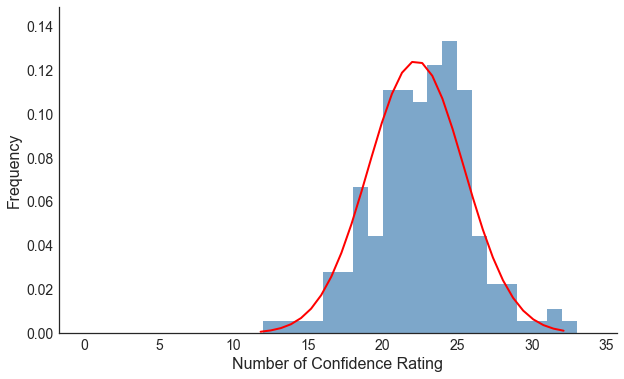

In [73]:
# Histogram of number of confidence rating - like a normal distribution
# 30 subjects, p=0.55
fig, axes = plt.subplots(1, 1, figsize=(10,6))

# normal
mu, sigma = 22.25, 3.21
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, 30, alpha=0,normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi))*np.exp( - (bins - mu)**2 / (2 * sigma**2) ),linewidth=2, color='r')

# histogram of confidence rating
n2 = plt.hist(tur_vid.delta_c, bins=np.arange(0, 35, 1), alpha=.7, normed=True, color='steelblue')

plt.setp(
    axes, 
    ylabel='Frequency', xlabel='Number of Confidence Rating'
)

sns.despine()

In [74]:
# more likely to be bimodal distribution
from sklearn import mixture

def fit_samples(samples):
    gmix = mixture.GMM(n_components=2, covariance_type='full')
    gmix.fit(samples)
    print(gmix.means_)
    colors = ['r' if i==0 else 'g' for i in gmix.predict(samples)]
    ax = plt.gca()
    ax.scatter(samples[:,0], samples[:,1], c=colors, alpha=0.8)
    plt.show()

### Question 2. Is there anything that makes some puzzles easier to identify? or more confident in identifying??
#### average by length (need to address AGGREGATION issues)

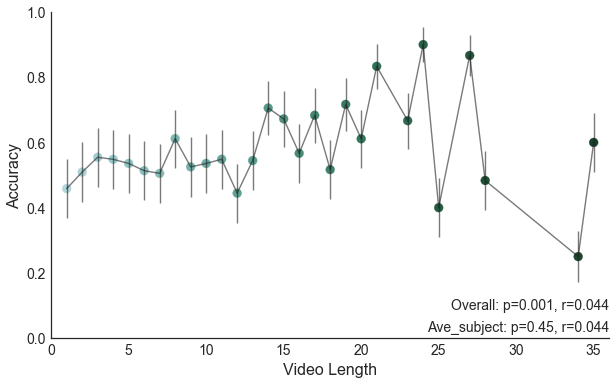

In [90]:
# showing the percentage correct for each video length
fig, axes = plt.subplots(1, 1, figsize=(10,6))

tur_len = dict()
for i in range(0,28,1):
    tur_len[i] = tur.loc[tur.length==length[i]]
y = [np.mean(tur_len[i]['feedback']) for i in range(0,28,1)]
yerr = [np.std(tur_len[i]['feedback'])/np.sqrt(30) for i in range(0,28,1)]
axes.errorbar(length, y, yerr,alpha=0.6)

# averaging correlations for each subject
tur_subject = dict()
r_values=[]
p_values=[]
r_pearson = []
for i in range(0,30,1):
    tur_subject[i] = tur.loc[tur.user_name == names[i]]
    slope, intercept, r_val, p_val, std_err = sts.linregress(tur_subject[i].length, tur_subject[i].feedback)
    r_values.append(r_val)
    p_values.append(p_val)
    r_pearson.append(np.corrcoef(tur_subject[i].length, tur_subject[i].feedback)[0, 1])
# average over within subject correlations
r_mean = np.average(r_values)
p_mean = np.average(p_values)
r_pmean = np.average(r_pearson)

# huge correlation using all trials
slope, intercept, r_value, p_value, std_err = sts.linregress(tur.length, tur.feedback)

if (p_value<0.001):
    text_1 = 'Overall: p<0.001, '+'r='+str(round(r_value,3))
else:
    text_1 = 'Overall: p='+str(round(p_value,3))+', '+'r='+str(round(r_value,3))
if (p_mean<0.001):
    text_2 = 'Ave_subject: p<0.001, '+'r='+str(round(r_mean,3))
else:
    text_2 = 'Ave_subject: p='+str(round(p_mean,3))+', '+'r='+str(round(r_mean,3))
plt.figtext(0.79,0.20,text_1, fontsize=14, ha='center', va='center', transform=axes.transAxes)
plt.figtext(0.773,0.15,text_2, fontsize=14, ha='center', va='center', transform=axes.transAxes)
if (round(r_pmean,2)!=round(r_mean,2)):
    plt.figtext(0.77,0.25,'Pearson: r='+str(round(r_mean,3)), fontsize=14, ha='center', va='center', transform=axes.transAxes)

plt.setp(
    axes, 
    xlim=[0, 36], xticks=np.arange(0, 36, 5), xlabel='Video Length',
    ylim=[0,1], yticks=np.arange(0, 1.1, 0.2), ylabel='Accuracy'
)

plt.scatter(tur_l.length, tur_l.feedback,s=80,color=greens)

sns.despine()
fig.savefig(fig_direc + 'accuracy_length.pdf')

In [91]:
np.corrcoef(tur.length,tur.feedback)[0,1]

0.043560757503934733

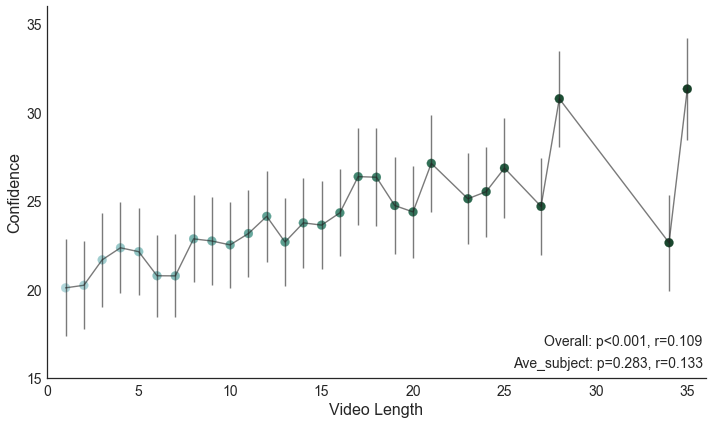

In [92]:
# showing the  onfidence rating for each video length, very good!
fig, axes = plt.subplots(1, 1, figsize=(10,6))

tur_len = dict()
for i in range(0,28,1):
    tur_len[i] = tur.loc[tur.length==length[i]]
y = [np.mean(tur_len[i]['delta_c']) for i in range(0,28,1)]
yerr = [np.std(tur_len[i]['delta_c'])/np.sqrt(30) for i in range(0,28,1)]
axes.errorbar(length, y, yerr,alpha=0.6)

# averaging correlations for each subject
tur_subject = dict()
r_values=[]
p_values=[]
r_pearson = []
for i in range(0,30,1):
    tur_subject[i] = tur.loc[tur.user_name == names[i]]
    slope, intercept, r_val, p_val, std_err = sts.linregress(tur_subject[i].length, tur_subject[i].delta_c)
    r_values.append(r_val)
    p_values.append(p_val)
    r_pearson.append(np.corrcoef(tur_subject[i].length, tur_subject[i].delta_c)[0, 1])
# average over within subject correlations
r_mean = np.average(r_values)
p_mean = np.average(p_values)
r_pmean = np.average(r_pearson)

# huge correlation using all trials
slope, intercept, r_value, p_value, std_err = sts.linregress(tur.length, tur.delta_c)

plt.scatter(tur_l.length, tur_l.delta_c,s=80,color=greens)
axes.set_xlim([0,36])

if (p_value<0.001):
    text_1 = 'Overall: p<0.001, '+'r='+str(round(r_value,3))
else:
    text_1 = 'Overall: p='+str(round(p_value,3))+', '+'r='+str(round(r_value,3))
if (p_mean<0.001):
    text_2 = 'Ave_subject: p<0.001, '+'r='+str(round(r_mean,3))
else:
    text_2 = 'Ave_subject: p='+str(round(p_mean,3))+', '+'r='+str(round(r_mean,3))
plt.figtext(0.87,0.20,text_1, fontsize=14, ha='center', va='center', transform=axes.transAxes)
plt.figtext(0.85,0.15,text_2, fontsize=14, ha='center', va='center', transform=axes.transAxes)
if (round(r_pmean,2)!=round(r_mean,2)):
    plt.figtext(0.85,0.25,'Pearson: r='+str(round(r_pmean,3)), fontsize=14, ha='center', va='center', transform=axes.transAxes)

plt.setp(
    axes, 
    xlim=[0, 36], xticks=np.arange(0, 36, 5), xlabel='Video Length',
    ylim=[15,36], yticks=np.arange(15, 36, 5), ylabel='Confidence'
)

plt.tight_layout()
sns.despine()
fig.savefig(fig_direc + 'confidence_length.pdf')

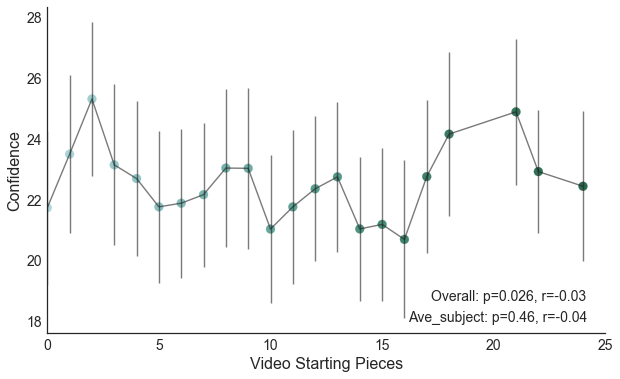

In [93]:
# showing the confidence rating for each video starting pieces
fig, axes = plt.subplots(1, 1, figsize=(10,6))

tur_pie = dict()
for i in range(0,22,1):
    tur_pie[i] = tur.loc[tur.start_pieces==pieces[i]]
y = [np.mean(tur_pie[i]['delta_c']) for i in range(0,22,1)]
yerr = [np.std(tur_pie[i]['delta_c'])/np.sqrt(30) for i in range(0,22,1)]
axes.errorbar(pieces, y, yerr,alpha=0.6)

# averaging correlations for each subject
tur_subject = dict()
r_values=[]
p_values=[]
r_pearson=[]
for i in range(0,30,1):
    tur_subject[i] = tur.loc[tur.user_name == names[i]]
    slope, intercept, r_val, p_val, std_err = sts.linregress(tur_subject[i].start_pieces, tur_subject[i].delta_c)
    r_values.append(r_val)
    p_values.append(p_val)
    r_pearson.append(np.corrcoef(tur_subject[i].start_pieces, tur_subject[i].delta_c)[0, 1])
# average over within subject correlations
r_mean = np.average(r_values)
p_mean = np.average(p_values)
r_pmean = np.average(r_pearson)

# huge correlation using all trials
slope, intercept, r_value, p_value, std_err = sts.linregress(tur.start_pieces, tur.delta_c)

if (p_value<0.001):
    text_1 = 'Overall: p<0.001, '+'r='+str(round(r_value,3))
else:
    text_1 = 'Overall: p='+str(round(p_value,3))+', '+'r='+str(round(r_value,3))
if (p_mean<0.001):
    text_2 = 'Ave_subject: p<0.001, '+'r='+str(round(r_mean,3))
else:
    text_2 = 'Ave_subject: p='+str(round(p_mean,3))+', '+'r='+str(round(r_mean,3))
plt.figtext(0.765,0.21,text_1, fontsize=14, ha='center', va='center', transform=axes.transAxes)
plt.figtext(0.75,0.16,text_2, fontsize=14, ha='center', va='center', transform=axes.transAxes)
if (round(r_pmean,2)!=round(r_mean,2)):
    plt.figtext(0.8,0.26,'Pearson: r='+str(round(r_pmean,3)), fontsize=14, ha='center', va='center', transform=axes.transAxes)

plt.scatter(tur_pieces.start_pieces, tur_pieces.delta_c,s=80,color=greens)
axes.set_xlim([0,25])

plt.setp(
    axes, 
    ylabel='Confidence', xlabel='Video Starting Pieces'
)

sns.despine()

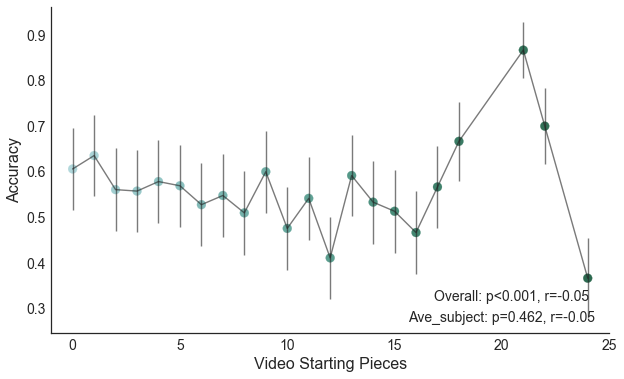

In [94]:
# showing the confidence rating for each video starting pieces
fig, axes = plt.subplots(1, 1, figsize=(10,6))

tur_pie = dict()
for i in range(0,22,1):
    tur_pie[i] = tur.loc[tur.start_pieces==pieces[i]]
y = [np.mean(tur_pie[i]['feedback']) for i in range(0,22,1)]
yerr = [np.std(tur_pie[i]['feedback'])/np.sqrt(30) for i in range(0,22,1)]
axes.errorbar(pieces, y, yerr,alpha=0.6)

# averaging correlations for each subject
tur_subject = dict()
r_values=[]
p_values=[]
r_pearson=[]
for i in range(0,30,1):
    tur_subject[i] = tur.loc[tur.user_name == names[i]]
    slope, intercept, r_val, p_val, std_err = sts.linregress(tur_subject[i].start_pieces, tur_subject[i].feedback)
    r_values.append(r_val)
    p_values.append(p_val)
    r_pearson.append(np.corrcoef(tur_subject[i].start_pieces, tur_subject[i].feedback)[0, 1])
# average over within subject correlations
r_mean = np.average(r_values)
p_mean = np.average(p_values)
r_pmean = np.average(r_pearson)

# huge correlation using all trials
slope, intercept, r_value, p_value, std_err = sts.linregress(tur.start_pieces, tur.feedback)

if (p_value<0.001):
    text_1 = 'Overall: p<0.001, '+'r='+str(round(r_value,3))
else:
    text_1 = 'Overall: p='+str(round(p_value,3))+', '+'r='+str(round(r_value,3))
if (p_mean<0.001):
    text_2 = 'Ave_subject: p<0.001, '+'r='+str(round(r_mean,3))
else:
    text_2 = 'Ave_subject: p='+str(round(p_mean,3))+', '+'r='+str(round(r_mean,3))
plt.figtext(0.765,0.21,text_1, fontsize=14, ha='center', va='center', transform=axes.transAxes)
plt.figtext(0.75,0.16,text_2, fontsize=14, ha='center', va='center', transform=axes.transAxes)
if (round(r_pmean,2)!=round(r_mean,2)):
    plt.figtext(0.8,0.26,'Pearson: r='+str(round(r_pmean,3)), fontsize=14, ha='center', va='center', transform=axes.transAxes)

plt.scatter(tur_pieces.start_pieces, tur_pieces.feedback,s=80,color=greens)
axes.set_xlim([-1,25])

plt.setp(
    axes, 
    ylabel='Accuracy', xlabel='Video Starting Pieces'
)

sns.despine()

In [95]:
# report correlations with video starting pieces
tur_subject = dict()
r_values=[]
p_values=[]
r_pearson = []
for i in range(0,30,1):
    tur_subject[i] = tur.loc[tur.user_name == names[i]]
    slope, intercept, r_val, p_val, std_err = sts.linregress(tur_subject[i].choice, tur_subject[i].start_pieces)
    r_values.append(r_val)
    p_values.append(p_val)
    r_pearson.append(np.corrcoef(tur_subject[i].start_pieces, tur_subject[i].choice)[0, 1])
# average over within subject correlations
r_mean = np.average(r_values)
p_mean = np.average(p_values)
r_pmean = np.average(r_pearson)
print(r_mean, p_mean)

slope, intercept, r_value, p_value, std_err = sts.linregress(tur.choice, tur.start_pieces)
print(slope,r_value,p_value)

0.0388811512325 0.461248183439
0.00697027533018 0.0377683855987 0.00550752225206


In [96]:
# report correlations with video starting pieces
tur_subject = dict()
r_values=[]
p_values=[]
r_pearson = []
for i in range(0,30,1):
    tur_subject[i] = tur.loc[tur.user_name == names[i]]
    slope, intercept, r_val, p_val, std_err = sts.linregress(tur_subject[i].feedback, tur_subject[i].bp_center)
    r_values.append(r_val)
    p_values.append(p_val)
    r_pearson.append(np.corrcoef(tur_subject[i].bp_center, tur_subject[i].feedback)[0, 1])
# average over within subject correlations
r_mean = np.average(r_values)
p_mean = np.average(p_values)
r_pmean = np.average(r_pearson)
print(r_mean, p_mean)

slope, intercept, r_value, p_value, std_err = sts.linregress(tur.feedback, tur.bp_center)
print(slope,r_value,p_value)

-0.053342607868 0.415550349936
-0.0434525653929 -0.0529321773955 9.96130882165e-05


In [97]:
# report correlations with video starting pieces
slope, intercept, r_value, p_value, std_err = sts.linregress(tur.delta_c, tur.elo)
print(slope,r_value,p_value)

1.07448585013 0.11085226276 3.10323073734e-16


### Question 2. Is there anything that makes some puzzles easier to identify? or more confident in identifying??
#### average by type (Aggregation issues)

0.0307407407407 0.0309183656994 0.023083868098


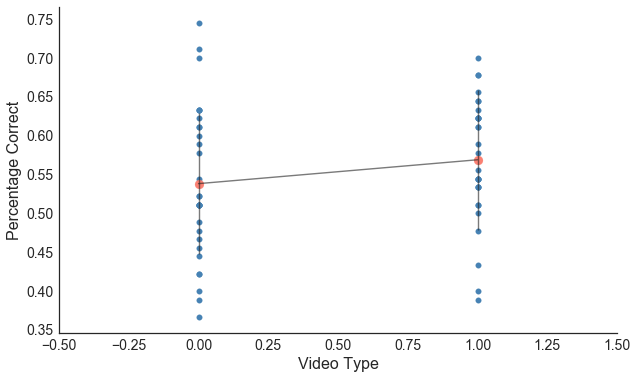

In [98]:
# showing the percentage correct for each video type
fig, axes = plt.subplots(1, 1, figsize=(10,6))

tur_type = dict()
for i in range(0,2,1):
    tur_type[i] = tur.loc[tur.clip_type==i]
y = [np.mean(tur_type[i]['feedback']) for i in range(0,2,1)]
yerr = [np.std(tur_type[i]['feedback'])/np.sqrt(30) for i in range(0,2,1)]
types=[0,1]
axes.errorbar(types, y, yerr,alpha=0.6)

slope, intercept, r_value, p_value, std_err = sts.linregress(tur.clip_type, tur.feedback)
print(slope,r_value,p_value)

plt.scatter(tur_st.clip_type, tur_st.feedback,color='steelblue')
plt.scatter(tur_t.clip_type, tur_t.feedback,s=80,color='salmon')

axes.set_xlim([-0.5,1.5])

plt.setp(
    axes, 
    ylabel='Percentage Correct', xlabel='Video Type'
)

sns.despine()

-0.375555555556 -0.0135459209217 0.319622934549


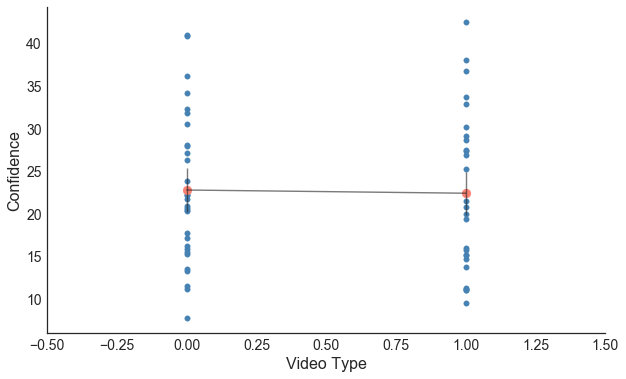

In [99]:
# showing the percentage correct for each video type
fig, axes = plt.subplots(1, 1, figsize=(10,6))

tur_type = dict()
for i in range(0,2,1):
    tur_type[i] = tur.loc[tur.clip_type==i]
y = [np.mean(tur_type[i]['delta_c']) for i in range(0,2,1)]
yerr = [np.std(tur_type[i]['delta_c'])/np.sqrt(30) for i in range(0,2,1)]
types=[0,1]
axes.errorbar(types, y, yerr,alpha=0.6)

slope, intercept, r_value, p_value, std_err = sts.linregress(tur.clip_type, tur.delta_c)
print(slope,r_value,p_value)

plt.scatter(tur_st.clip_type, tur_st.delta_c,color='steelblue')
plt.scatter(tur_t.clip_type, tur_t.delta_c,s=80,color='salmon')

axes.set_xlim([-0.5,1.5])

plt.setp(
    axes, 
    ylabel='Confidence', xlabel='Video Type'
)

sns.despine()

#### Elo

In [100]:
tur_sub.head()

,user_name,clip_id,length,choice,feedback,timestamp,clip_type,delta_c,start_pieces,wp_center,bp_center,human,elo
0,AD,89.5,9.588889,60.338889,0.533333,1.485973e+12,0.5,41.683333,6.55,0.738889,0.788889,0.611111,76.0
1,AF,89.5,9.588889,50.833333,0.511111,1.478103e+12,0.5,10.388889,6.55,0.738889,0.788889,0.533333,76.0
2,AJ,89.5,9.588889,42.344444,0.622222,1.478733e+12,0.5,33.566667,6.55,0.738889,0.788889,0.411111,-26.0
3,AP,89.5,9.588889,51.394444,0.594444,1.479484e+12,0.5,20.905556,6.55,0.738889,0.788889,0.483333,61.0
4,AR,89.5,9.588889,50.100000,0.572222,1.481145e+12,0.5,21.544444,6.55,0.738889,0.788889,0.550000,71.0


accuracy: 0.187608611426
accuracy: SpearmanrResult(correlation=0.086665937471066684, pvalue=0.64883796814050132)


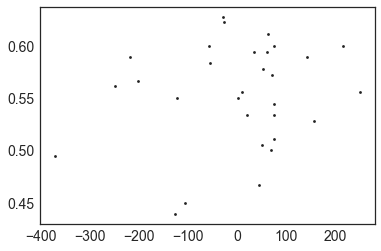

confidence: 0.178088245983
confidence: SpearmanrResult(correlation=0.16095280897495445, pvalue=0.39550570730000678)


In [183]:
print("accuracy: "+ str(np.corrcoef(tur_sub.feedback, tur_sub.elo)[0,1]))
print("accuracy: "+ str(sts.spearmanr(tur_sub.feedback, tur_sub.elo)))
plt.plot(tur_sub.elo,tur_sub.feedback,'.')
plt.show()
print("confidence: "+ str(np.corrcoef(tur_sub.delta_c, tur_sub.elo)[0,1]))
print("confidence: "+ str(sts.spearmanr(tur_sub.delta_c, tur_sub.elo)))

slope: 6.81102581344935e-05, r: 0.18760861142608518, p: 0.32082558086846796
6.81102581345e-05


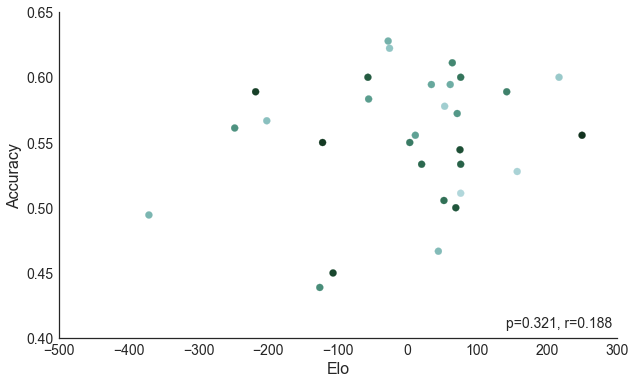

In [184]:
# showing the percentage correct for elo level
fig, axes = plt.subplots(1, 1, figsize=(10,6))

'''
# averaging correlations for each video id
tur_vidID= dict()
r_values=[]
p_values=[]
r_pearson=[]
for i in range(0,180,1):
    tur_vidID[i] = tur.loc[tur.clip_id == i]
    slope, intercept, r_val, p_val, std_err = sts.linregress(tur_vidID[i].elo, tur_vidID[i].feedback)
    r_values.append(r_val)
    p_values.append(p_val)
    r_pearson.append(np.corrcoef(tur_vidID[i].elo, tur_vidID[i].feedback)[0, 1])
# average over within subject correlations
r_mean = np.average(r_values)
p_mean = np.average(p_values)
r_pmean = np.average(r_pearson)
'''

slope, intercept, r_val, p_val, std_err = sts.linregress(tur_sub.elo, tur_sub.feedback)
print("slope: {}, r: {}, p: {}".format(slope,r_val, p_val))

# huge correlation using all trials
slope, intercept, r_value, p_value, std_err = sts.linregress(tur.elo, tur.feedback)
print(slope)

text_1 = 'p='+str(round(p_val,3))+', '+'r='+str(round(r_val,3))
plt.figtext(0.82,0.16,text_1, fontsize=14, ha='center', va='center', transform=axes.transAxes)
        
tur_sub = tur_sub.sort_values(by='timestamp')
plt.scatter(tur_sub.elo, tur_sub.feedback,s=50,color=greens)

plt.setp(
    axes, 
    xlim=[-500,300], xticks=np.arange(-500, 301, 100), xlabel='Elo',
    ylim=[0.40,0.65], yticks=np.arange(0.40, 0.66, 0.05), ylabel='Accuracy'
)

sns.despine()
fig.savefig(fig_direc + "Accuracy_elo.pdf")

slope: 0.011436375972180682, r: 0.1780882459832344, p: 0.34642916252120515
0.0114363759722


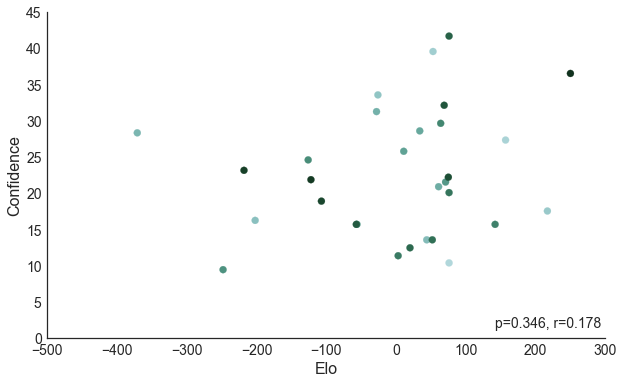

In [104]:
# showing the percentage correct for elo level
fig, axes = plt.subplots(1, 1, figsize=(10,6))

'''
# averaging correlations for each video id
tur_vidID= dict()
r_values=[]
p_values=[]
for i in range(0,180,1):
    tur_vidID[i] = tur.loc[tur.clip_id == i]
    slope, intercept, r_val, p_val, std_err = sts.linregress(tur_vidID[i].elo, tur_vidID[i].delta_c)
    r_values.append(r_val)
    p_values.append(p_val)
    r_pearson.append(np.corrcoef(tur_vidID[i].elo, tur_vidID[i].delta_c)[0, 1])
# average over within subject correlations
r_mean = np.average(r_values)
p_mean = np.average(p_values)
print(p_mean)
r_pmean = np.average(r_pearson)
'''

slope, intercept, r_val, p_val, std_err = sts.linregress(tur_sub.elo, tur_sub.delta_c)
print("slope: {}, r: {}, p: {}".format(slope,r_val, p_val))

# huge correlation using all trials
slope, intercept, r_value, p_value, std_err = sts.linregress(tur.elo, tur.delta_c)
print(slope)

text_1 = 'p='+str(round(p_val,3))+', '+'r='+str(round(r_val,3))
plt.figtext(0.82,0.16,text_1, fontsize=14, ha='center', va='center', transform=axes.transAxes)

tur_sub = tur_sub.sort_values(by='timestamp')
plt.scatter(tur_sub.elo, tur_sub.delta_c,s=50,color=greens)


plt.setp(
    axes, 
    xlim=[-500,300], xticks=np.arange(-500, 301, 100), xlabel='Elo',
    ylim=[0,45], yticks=np.arange(0, 50, 5), ylabel='Confidence'
)

sns.despine()
fig.savefig(fig_direc + 'confidence_elo')

#### by clip id

0.000422886851789 0.0442009455063 0.0011584049665


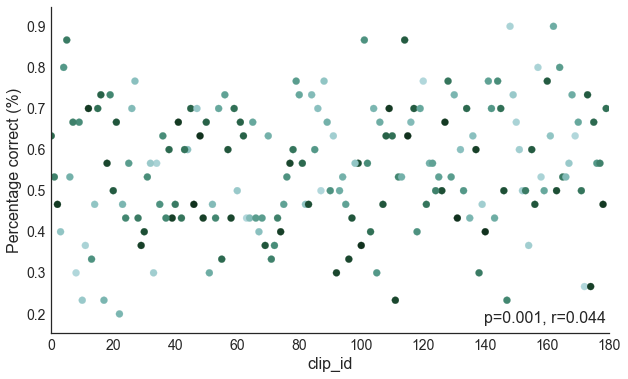

In [105]:
# showing the percentage correct for each video id
fig, axes = plt.subplots(1, 1, figsize=(10,6))

slope, intercept, r_value, p_value, std_err = sts.linregress(tur.clip_id, tur.feedback)
print(slope,r_value,p_value)

plt.scatter(tur_vid.clip_id, tur_vid.feedback,s=50,color=greens)

axes.set_xlim([0,180])

plt.setp(
    axes, 
    ylabel='Percentage correct (%)', xlabel='clip_id'
)
if (p_value<0.001):
    text = 'p<0.001, '+'r='+str(round(r_value,3))
else:
    text = 'p='+str(round(p_value,3))+', '+'r='+str(round(r_value,3))
plt.figtext(0.81,0.16,text, fontsize=16, ha='center', va='center', transform=axes.transAxes)

sns.despine()

-0.00388400190678 -0.0145585779169 0.284780649955


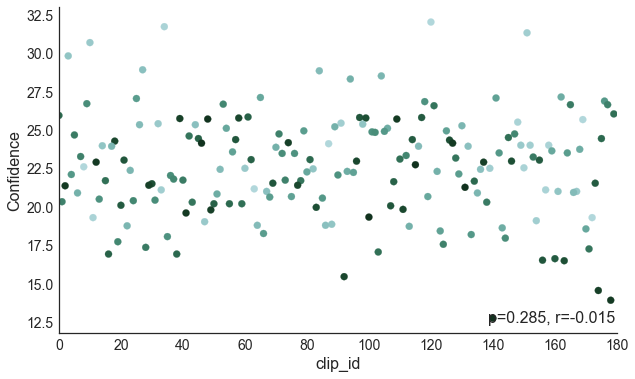

In [106]:
# showing the relative confidence level for each video id
fig, axes = plt.subplots(1, 1, figsize=(10,6))

slope, intercept, r_value, p_value, std_err = sts.linregress(tur.clip_id, tur.delta_c)
print(slope,r_value,p_value)

plt.scatter(tur_vid.clip_id, tur_vid.delta_c,s=50,color=greens)

axes.set_xlim([0,180])

plt.setp(
    axes, 
    ylabel='Confidence', xlabel='clip_id'
)
if (p_value<0.001):
    text = 'p<0.001, '+'r='+str(round(r_value,3))
else:
    text = 'p='+str(round(p_value,3))+', '+'r='+str(round(r_value,3))
plt.figtext(0.81,0.16,text, fontsize=16, ha='center', va='center', transform=axes.transAxes)

sns.despine()

### Question 2. Is there anything that makes some puzzles easier to identify? or more confident in identifying??
#### Questionnaire?

In [107]:
'''
client = pymongo.MongoClient('localhost', 27017)
db = client.gamesdb
C = db.turing
cursor = C.find({'task':'turingQ'})
turingQ = pd.DataFrame(list(cursor))
'''

"\nclient = pymongo.MongoClient('localhost', 27017)\ndb = client.gamesdb\nC = db.turing\ncursor = C.find({'task':'turingQ'})\nturingQ = pd.DataFrame(list(cursor))\n"

In [108]:
'''
turingQ = turingQ.loc[turingQ.user_name.isin(names)]
'''

'\nturingQ = turingQ.loc[turingQ.user_name.isin(names)]\n'

In [109]:
#turingQ = turingQ[['user_name','free-response','q0','q1','q2','q3','q4','q5','q6','q7','q8','q9']]

In [110]:
#turingQ.to_csv(dump_dir+'turingQ.csv',index=False)


In [191]:
elo = pd.read_csv(dump_dir+'ratings_tur.csv')
turingQ = pd.read_csv(dump_dir+'turingQ.csv')
turingQ = pd.merge(turingQ,elo,on='user_name')
turingQ = pd.merge(turingQ, pd.DataFrame(tur_sub[['user_name','delta_c']]), on='user_name')
turingQ = pd.merge(turingQ, pd.DataFrame(tur_sub[['user_name','feedback']]), on='user_name')
turingQ = pd.merge(turingQ, pd.DataFrame(tur_sub[['user_name','human']]), on='user_name')
for i in range(0,10,1):
    turingQ['q'+str(i)]=turingQ['q'+str(i)]-50

In [194]:
print([turingQ['q'+str(i)].mean() for i in range(10)])

[-11.379310344827585, -19.137931034482758, -14.137931034482758, 25.17241379310345, -6.206896551724138, 3.2758620689655173, -11.551724137931034, -20.517241379310345, -5.862068965517241, -11.206896551724139]


KeyError: 'q10'

In [115]:
# percentage correct for each subject as a function (linear regression) of their playing strength and claimed strategies
formula = 'feedback ~ q0+q1+q2+q3+q4+q5+q6+q7+q8+q9+elo'
lm = ols(formula, turingQ).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               feedback   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     2.994
Date:                Thu, 18 Jan 2018   Prob (F-statistic):             0.0209
Time:                        19:09:27   Log-Likelihood:                 59.979
No. Observations:                  29   AIC:                            -95.96
Df Residuals:                      17   BIC:                            -79.55
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5303      0.015     36.355      0.0

In [116]:
sts.spearmanr(turingQ.q7, turingQ.feedback)

SpearmanrResult(correlation=-0.22716759566770225, pvalue=0.23597973380661219)

In [117]:
np.corrcoef(turingQ.q9, turingQ.feedback)[0, 1]

-0.43050367453654997

In [118]:
sts.spearmanr(turingQ.q3, turingQ.delta_c)
# q1, 3 (positive), 7

SpearmanrResult(correlation=0.57282834396846272, pvalue=0.0011635585909453307)

In [119]:
np.corrcoef(turingQ.q3, turingQ.delta_c)[0, 1]

0.56449228706737453

In [120]:
slope, intercept, r_value, p_value, std_err = sts.linregress(turingQ.q1, turingQ.delta_c)
print(slope,r_value,p_value)

-0.104966891538 -0.3471892713 0.0649930240893


In [121]:
sts.spearmanr(turingQ.q9, turingQ.human)

SpearmanrResult(correlation=0.2632369965601033, pvalue=0.1676805087404904)

In [122]:
np.corrcoef(turingQ.q9, turingQ.human)[0, 1]

0.31505611062368893

In [123]:
formula = 'delta_c ~ q0+q1+q2+q3+q4+q5+q6+q7+q8+q9+elo'
lm = ols(formula, turingQ).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                delta_c   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     1.892
Date:                Thu, 18 Jan 2018   Prob (F-statistic):              0.115
Time:                        19:09:33   Log-Likelihood:                -90.727
No. Observations:                  29   AIC:                             205.5
Df Residuals:                      17   BIC:                             221.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.3473      2.636      6.582      0.0

In [124]:
formula = 'human ~ q0+q1+q2+q3+q4+q5+q6+q7+q8+q9+elo'
lm = ols(formula, turingQ).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  human   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     1.419
Date:                Thu, 18 Jan 2018   Prob (F-statistic):              0.250
Time:                        19:09:34   Log-Likelihood:                 44.659
No. Observations:                  29   AIC:                            -65.32
Df Residuals:                      17   BIC:                            -48.91
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5606      0.025     22.662      0.0

In [181]:
turingQ['q0_weighted']

0     0.25
1    -0.35
2    -0.20
3    -0.50
4    -0.40
5     0.30
6    -0.10
7     0.30
8    -0.40
9    -0.30
10   -0.30
11    0.35
12   -0.30
13    0.15
14    0.30
15   -0.40
16   -0.25
17   -0.30
18   -0.35
19   -0.30
20    0.15
21   -0.45
22   -0.10
23    0.35
24   -0.20
25    0.30
26   -0.45
27   -0.40
28    0.30
Name: q0_weighted, dtype: float64

### Question 1. Does people’s confidence reflect their accuracy in distinguishing the video types? 
#### average by subject for cross subject analysis

0.00271666830812
0.00414986359828


FileNotFoundError: [Errno 2] No such file or directory: 'Figs/Q1_1.png'

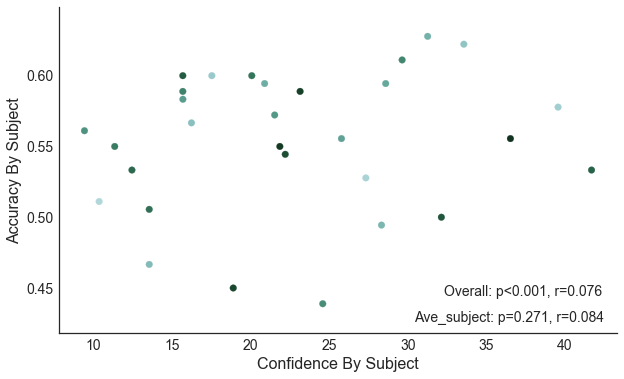

In [125]:
# showing the percentage correct for each video length
fig, axes = plt.subplots(1, 1, figsize=(10,6))

# averaging correlations for each subject
tur_subject = dict()
r_values=[]
p_values=[]
r_pearson=[]
slopes = []
for i in range(0,30,1):
    tur_subject[i] = tur.loc[tur.user_name == names[i]]
    slope, intercept, r_val, p_val, std_err = sts.linregress(tur_subject[i].delta_c, tur_subject[i].feedback)
    slopes.append(slope)
    r_values.append(r_val)
    p_values.append(p_val)
    r_pearson.append(np.corrcoef(tur_subject[i].feedback, tur_subject[i].delta_c)[0, 1])
# average over within subject correlations
r_mean = np.average(r_values)
p_mean = np.average(p_values)
r_pmean = np.average(r_pearson)

# huge correlation using all trials
slope, intercept, r_value, p_value, std_err = sts.linregress(tur.delta_c, tur.feedback)
print(slope)

if (p_value<0.001):
    text_1 = 'Overall: p<0.001, '+'r='+str(round(r_value,3))
else:
    text_1 = 'Overall: p='+str(round(p_value,3))+', '+'r='+str(round(r_value,3))
if (p_mean<0.001):
    text_2 = 'Ave_subject: p<0.001, '+'r='+str(round(r_mean,3))
else:
    text_2 = 'Ave_subject: p='+str(round(p_mean,3))+', '+'r='+str(round(r_mean,3))
plt.figtext(0.77,0.22,text_1, fontsize=14, ha='center', va='center', transform=axes.transAxes)
plt.figtext(0.75,0.16,text_2, fontsize=14, ha='center', va='center', transform=axes.transAxes)
print(np.average(slopes))

plt.scatter(tur_sub.delta_c, tur_sub.feedback,color=greens,s=45)

#axes.set_xlim([0,36])

plt.setp(
    axes, 
    ylabel='Accuracy By Subject', xlabel='Confidence By Subject'
)

sns.despine()
fig.savefig('Figs/Q1_1.png', bbox_inches='tight')

### 1. Does people’s confidence reflect their accuracy in distinguishing the video types? 
#### average by subject and length for within subject

0.00271666830812 0.0757538086764 2.49720177356e-08


FileNotFoundError: [Errno 2] No such file or directory: 'Figs/Q1_2.png'

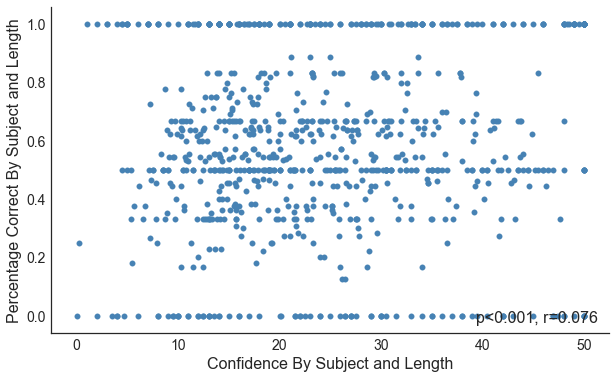

In [126]:
# showing the percentage correct for each video length
fig, axes = plt.subplots(1, 1, figsize=(10,6))

tur_sl = tur_sl.sort_values(by='feedback')
slope, intercept, r_value, p_value, std_err = sts.linregress(tur.delta_c, tur.feedback)
print(slope,r_value,p_value)

plt.scatter(tur_sl.delta_c, tur_sl.feedback,color='steelblue')

plt.setp(
    axes, 
    ylabel='Percentage Correct By Subject and Length', xlabel='Confidence By Subject and Length'
)

if (p_value<0.001):
    text = 'p<0.001, '+'r='+str(round(r_value,3))
else:
    text = 'p='+str(round(p_value,3))+', '+'r='+str(round(r_value,3))
plt.figtext(0.80,0.16,text, fontsize=16, ha='center', va='center', transform=axes.transAxes)

sns.despine()
fig.savefig('Figs/Q1_2.png', bbox_inches='tight')

In [127]:
sts.spearmanr(tur_sl.delta_c, tur_sl.feedback)

SpearmanrResult(correlation=0.073463305392031636, pvalue=0.033264568647665485)

### 1. Does people’s confidence reflect their accuracy in distinguishing the video types? 
#### average by subject and type for within subject

0.00271666830812 0.0757538086764 2.49720177356e-08


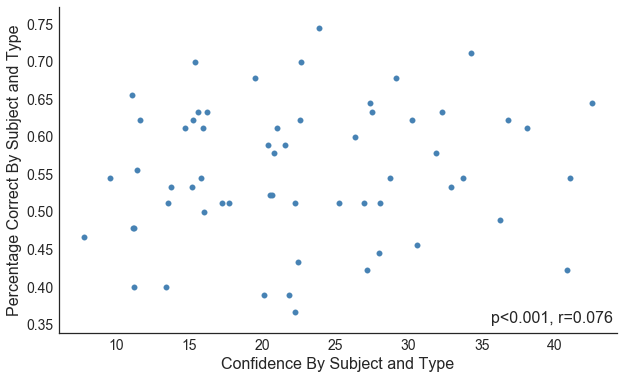

In [131]:
# showing the percentage correct for each video length
fig, axes = plt.subplots(1, 1, figsize=(10,6))

tur_st = tur_st.sort_values(by='feedback')

slope, intercept, r_value, p_value, std_err = sts.linregress(tur.delta_c, tur.feedback)
print(slope,r_value,p_value)

plt.scatter(tur_st.delta_c, tur_st.feedback,color='steelblue')

#axes.set_xlim([0,36])

plt.setp(
    axes, 
    ylabel='Percentage Correct By Subject and Type', xlabel='Confidence By Subject and Type'
)

if (p_value<0.001):
    text = 'p<0.001, '+'r='+str(round(r_value,3))
else:
    text = 'p='+str(round(p_value,3))+', '+'r='+str(round(r_value,3))
plt.figtext(0.81,0.16,text, fontsize=16, ha='center', va='center', transform=axes.transAxes)

sns.despine()
fig.savefig(fig_direc + 'Q1_3.pdf', bbox_inches='tight')

In [132]:
sts.spearmanr(tur_st.delta_c, tur_st.feedback)

SpearmanrResult(correlation=0.13453049160226321, pvalue=0.30545020292347103)

### Question 3. What affects report as human (binary, logistic)
#### use all data in tur

In [133]:
# logistic regression
# should try to use formula rather than using package
'''
dummy_vid = pd.get_dummies(tur['clip_id'],prefix='vid')
data = tur.join(dummy_vid)
'''
data = tur

In [134]:
data.head()

,user_name,clip_id,length,choice,feedback,timestamp,clip_type,delta_c,start_pieces,wp_center,bp_center,human,elo
0,AF,58,16,24,0,1478100672688,1,26,4,1,1,0,76
1,AF,146,1,63,0,1478100685909,0,13,9,1,1,1,76
2,AF,168,14,61,0,1478100707442,0,11,0,0,0,1,76
3,AF,43,15,42,0,1478100760990,1,8,0,0,0,0,76
4,AF,72,12,42,0,1478100797038,1,8,4,1,1,0,76


In [135]:
data = data.drop('timestamp',axis=1)

In [136]:
data = data[['user_name','choice','human','feedback','clip_id','clip_type','delta_c','length','elo','start_pieces','wp_center','bp_center']]
#data = data[['choice','human','feedback','clip_id','delta_c','clip_type','length','elo','start_pieces']]

In [137]:
data['center'] = data['wp_center']*data['bp_center']
data['intercept'] = 1.0

In [138]:
# log model

#train_cols = data.columns[5:13]
train_cols = ['length','elo','start_pieces','center','intercept']

logit = sm.Logit(data['human'], data[train_cols])

# fit the model
result = logit.fit()
print(result.summary())
#print result.conf_int()
#print np.exp(result.params)
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
#print np.exp(conf)
predictions = result.predict()
predictions_nominal = [ 0 if x < 0.5 else 1 for x in predictions]
#print confusion_matrix(data['human'], predictions_nominal)
print(classification_report(data['human'], predictions_nominal, digits=3))

Optimization terminated successfully.
         Current function value: 0.683348
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                  human   No. Observations:                 5400
Model:                          Logit   Df Residuals:                     5395
Method:                           MLE   Df Model:                            4
Date:                Thu, 18 Jan 2018   Pseudo R-squ.:                 0.01347
Time:                        19:10:28   Log-Likelihood:                -3690.1
converged:                       True   LL-Null:                       -3740.4
                                        LLR p-value:                 6.873e-21
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
length           0.0400      0.004      9.044      0.000       0.031       0.049
elo              0.0004

In [139]:
np.corrcoef(data['human'], data['delta_c'])[0,1]

-0.077785024167323594

In [140]:
# log model
data['inter_lt']=data['length']*data['clip_type']
data['inter_spt']=data['clip_type']*data['start_pieces']
train_cols = ['length','elo','start_pieces','intercept','wp_center','bp_center']

logit = sm.Logit(data['human'], data[train_cols])

# fit the model
result = logit.fit()
print(result.summary())
#print result.conf_int()
#print np.exp(result.params)
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
#print np.exp(conf)
predictions = result.predict()
predictions_nominal = [ 0 if x < 0.5 else 1 for x in predictions]
#print confusion_matrix(data['human'], predictions_nominal)
print(classification_report(data['human'], predictions_nominal, digits=3))

Optimization terminated successfully.
         Current function value: 0.682842
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                  human   No. Observations:                 5400
Model:                          Logit   Df Residuals:                     5394
Method:                           MLE   Df Model:                            5
Date:                Thu, 18 Jan 2018   Pseudo R-squ.:                 0.01420
Time:                        19:10:29   Log-Likelihood:                -3687.3
converged:                       True   LL-Null:                       -3740.4
                                        LLR p-value:                 2.611e-21
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
length           0.0405      0.004      9.129      0.000       0.032       0.049
elo              0.0004

### 4. What affects confidence (logistic, ANOVA)
#### use all data in tur
#### use AVONA first to test for interactions, then use logistic reg

In [141]:
# linear
formula = 'delta_c ~ length + elo + start_pieces+center'
lm = ols(formula, data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                delta_c   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     33.93
Date:                Thu, 18 Jan 2018   Prob (F-statistic):           5.28e-28
Time:                        19:10:30   Log-Likelihood:                -21793.
No. Observations:                5400   AIC:                         4.360e+04
Df Residuals:                    5395   BIC:                         4.363e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       20.8583      0.464     44.966   

In [142]:
# linear - using choice rather than delta_c just to check - higher power and starting pieces also signfiicant - but cannot interpret this
formula = 'choice ~ C(clip_type) +length + elo + start_pieces'
#formula = 'choice ~ clip_type +length + elo + start_pieces'
lm = ols(formula, data).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 choice   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     53.70
Date:                Thu, 18 Jan 2018   Prob (F-statistic):           1.90e-44
Time:                        19:10:30   Log-Likelihood:                -25264.
No. Observations:                5400   AIC:                         5.054e+04
Df Residuals:                    5395   BIC:                         5.057e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            39.0688      0.88

In [143]:
# test for interaction between clip type and length, not significant
interX_lm = ols("delta_c ~ C(clip_type)*length + length*start_pieces + C(clip_type)+ length + elo + start_pieces", data).fit()
#interX_lm = ols("delta_c ~ clip_type*length + length*start_pieces + clip_type+ length + elo + start_pieces", data).fit()
print(interX_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                delta_c   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     26.10
Date:                Thu, 18 Jan 2018   Prob (F-statistic):           8.84e-31
Time:                        19:10:30   Log-Likelihood:                -21783.
No. Observations:                5400   AIC:                         4.358e+04
Df Residuals:                    5393   BIC:                         4.363e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [144]:
#interM_lm = ols("delta_c ~ C(clip_type)+ length + elo + start_pieces", data=data).fit()
interM_lm = ols("delta_c ~ clip_type + length + elo + start_pieces", data=data).fit()

table2 = anova_lm(interM_lm)
print(table2)

                  df        sum_sq       mean_sq          F        PR(>F)
clip_type        1.0  1.904067e+02    190.406667   1.015961  3.135241e-01
length           1.0  1.334226e+04  13342.263768  71.190903  4.119606e-17
elo              1.0  1.275129e+04  12751.292360  68.037631  1.996666e-16
start_pieces     1.0  2.944475e+02    294.447475   1.571096  2.101022e-01
Residual      5395.0  1.011105e+06    187.415290        NaN           NaN


C:\Users\Bas\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Bas\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Bas\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


### 5. What affects correctness (binary, logistic, try OLS)
#### use all data in tur

In [145]:
#table1 = anova_lm(lm, interX_lm)

interM_lm = ols("feedback ~  C(clip_type)*length + length + elo + start_pieces + center", data=data).fit()
print(interM_lm.summary())

table2 = anova_lm(interM_lm)
print(table2)

                            OLS Regression Results                            
Dep. Variable:               feedback   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     13.99
Date:                Thu, 18 Jan 2018   Prob (F-statistic):           7.25e-16
Time:                        19:10:31   Log-Likelihood:                -3846.4
No. Observations:                5400   AIC:                             7707.
Df Residuals:                    5393   BIC:                             7753.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

C:\Users\Bas\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Bas\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Bas\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [146]:
# log model: of correctness

train_cols = data.columns[6:11]
train_cols = ['delta_c', 'length', 'elo', 'start_pieces', 'intercept','center']

logit = sm.Logit(data['feedback'], data[train_cols])
# fit the model
result = logit.fit()
print(result.summary())
#print result.conf_int()
#print np.exp(result.params)
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
#print np.exp(conf)
predictions = result.predict()
predictions_nominal = [ 0 if x < 0.5 else 1 for x in predictions]
#print confusion_matrix(data['human'], predictions_nominal)
print(classification_report(data['feedback'], predictions_nominal, digits=3))

Optimization terminated successfully.
         Current function value: 0.682226
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:               feedback   No. Observations:                 5400
Model:                          Logit   Df Residuals:                     5394
Method:                           MLE   Df Model:                            5
Date:                Thu, 18 Jan 2018   Pseudo R-squ.:                0.007538
Time:                        19:10:31   Log-Likelihood:                -3684.0
converged:                       True   LL-Null:                       -3712.0
                                        LLR p-value:                 8.280e-11
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
delta_c          0.0103      0.002      5.068      0.000       0.006       0.014
length           0.0093

In [147]:
np.corrcoef(data['feedback'],data['center'])[0,1]

-0.059002641867863061

In [148]:
train_cols

['delta_c', 'length', 'elo', 'start_pieces', 'intercept', 'center']

In [149]:
tur_lt = tur.groupby(['length','clip_type']).mean().reset_index()
tur_t0 = tur.loc[tur.clip_type==0]
tur_t1 = tur.loc[tur.clip_type==1]
tur_st1 = tur_t1.groupby(['user_name']).mean().reset_index()
tur_st0 = tur_t0.groupby(['user_name']).mean().reset_index()

In [150]:
np.corrcoef(tur_st0.elo, tur_st0.feedback)[0,1]

-0.038639160680698816

In [151]:
sts.spearmanr(tur_st0.elo, tur_st0.feedback)

SpearmanrResult(correlation=-0.1422038395295816, pvalue=0.45349048730946995)

In [152]:
sts.spearmanr(tur_sub.elo, tur_sub.feedback)

SpearmanrResult(correlation=0.086665937471066684, pvalue=0.64883796814050132)

## With subjects' model fitting parameters
### Question: does a particular parameter predict questionnair choices of strategies, or performance, or binary choice, or confidence?

In [153]:
#tur_param = read_csv(dump_dir + 'params_tur_final_short.csv')
tur_param = pd.DataFrame.from_csv(dump_dir + 'params_tur_final_short.csv')

In [154]:
tur_param.reset_index(inplace=True)  

In [155]:
tur_param.head(5)

,user_name,pruning,gamma,feature_drop,lapse,scaling,center,2-conn,2-unc,3-in-a-row,4-in-a-row
0,AF,1.6168,0.009035,0.15734,0.010000,0.54988,0.69911,1.09400,0.22685,3.3035,15.738
1,AF,1.0001,0.032218,0.20299,0.029529,0.49411,0.98822,1.34510,0.99411,5.3410,29.906
2,AF,2.2955,0.009786,0.17821,0.015863,0.56828,0.98900,0.91372,0.56471,4.2575,17.661
3,AF,5.0000,0.003684,0.20145,0.020000,0.25000,1.06670,1.39220,0.30000,3.6923,15.000
4,AF,0.1000,0.018069,0.19878,0.021612,0.52833,0.88889,0.85964,0.40000,3.5000,18.333


In [156]:
tur_param = tur_param.groupby([tur_param.user_name]).mean().reset_index()


In [157]:
list = ['pruning', 'gamma','feature_drop','lapse','scaling','center','2-conn','2-unc','3-in-a-row','4-in-a-row']
len(list)

10

In [158]:
for i in range(0,10,1):
    tur_sub = pd.merge(tur_sub,pd.DataFrame(tur_param[['user_name',list[i]]]),on='user_name')

In [159]:
for i in range(0,10,1):
    print(list[i]+": "+str(np.corrcoef(tur_sub.elo, tur_sub[list[i]])[0,1]))

pruning: 0.0618417340894
gamma: -0.388959347359
feature_drop: -0.768654547529
lapse: -0.525320480993
scaling: -0.317874106486
center: 0.310372035836
2-conn: 0.0436301954988
2-unc: 0.218096649072
3-in-a-row: 0.385122853609
4-in-a-row: 0.181928714641


In [160]:
for i in range(0,10,1):
    print(list[i]+": "+str(sts.spearmanr(tur_sub.elo, tur_sub[list[i]])))

pruning: SpearmanrResult(correlation=0.082127762421121228, pvalue=0.66614239689939259)
gamma: SpearmanrResult(correlation=-0.33674608277278162, pvalue=0.068816655853432981)
feature_drop: SpearmanrResult(correlation=-0.65457384628866533, pvalue=8.6991525056692576e-05)
lapse: SpearmanrResult(correlation=-0.31137327812235394, pvalue=0.093948903726519289)
scaling: SpearmanrResult(correlation=-0.3585577920336756, pvalue=0.05169052444299934)
center: SpearmanrResult(correlation=0.31938574274880477, pvalue=0.085359237133774621)
2-conn: SpearmanrResult(correlation=0.034943248509799546, pvalue=0.85455069198535827)
2-unc: SpearmanrResult(correlation=0.30870245658020362, pvalue=0.09695298220107397)
3-in-a-row: SpearmanrResult(correlation=0.59492549851397569, pvalue=0.0005253435524600669)
4-in-a-row: SpearmanrResult(correlation=0.21477856568125198, pvalue=0.2543832802388693)


### We can see: tree size (1/gamma), feature drop, lapse, active scaling, center weight, and 3-in-a-row are relatively strongly correlated with Elo (consistent with previous results)
#### The cleanest: Feature drop rate, 3 in a row

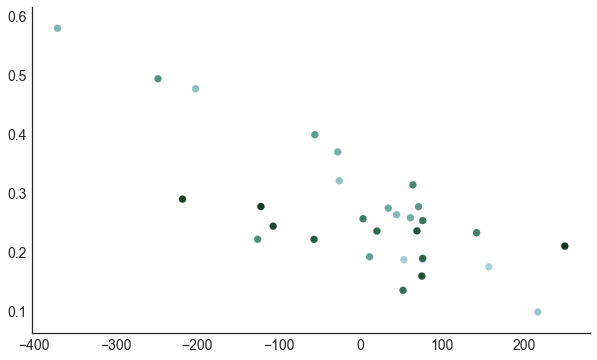

In [161]:
# showing the percentage correct for elo level
fig, axes = plt.subplots(1, 1, figsize=(10,6))


plt.scatter(tur_sub.elo, tur_sub['feature_drop'],s=50,color=greens)

sns.despine()

In [162]:
for i in range(0,10,1):
    print(list[i]+": "+str(np.corrcoef(tur_sub.choice, tur_sub[list[i]])[0,1]))

pruning: 0.159095322557
gamma: 0.0282300731617
feature_drop: -0.0104156869484
lapse: 0.156480870177
scaling: -0.0678020234376
center: -0.16964257014
2-conn: 0.0168820019283
2-unc: 0.477630368989
3-in-a-row: 0.445637302178
4-in-a-row: 0.0460636904592


In [163]:
for i in range(0,10,1):
    print(list[i]+": "+str(sts.spearmanr(tur_sub.choice, tur_sub[list[i]])))

pruning: SpearmanrResult(correlation=0.13058954393770855, pvalue=0.49155981918115965)
gamma: SpearmanrResult(correlation=0.17285873192436038, pvalue=0.36100144122309663)
feature_drop: SpearmanrResult(correlation=-0.14260289210233593, pvalue=0.45221109012212057)
lapse: SpearmanrResult(correlation=0.046941045606229144, pvalue=0.80543651525988347)
scaling: SpearmanrResult(correlation=-0.050945494994438262, pvalue=0.7891945915897941)
center: SpearmanrResult(correlation=0.013570634037819799, pvalue=0.94325913936572303)
2-conn: SpearmanrResult(correlation=0.10656284760845385, pvalue=0.57516047496367917)
2-unc: SpearmanrResult(correlation=0.17018909899888765, pvalue=0.36857844726721367)
3-in-a-row: SpearmanrResult(correlation=0.2413793103448276, pvalue=0.19878819431788416)
4-in-a-row: SpearmanrResult(correlation=-0.046496106785317015, pvalue=0.80724621401050078)


In [164]:
for i in range(0,10,1):
    print(list[i]+": "+str(np.corrcoef(tur_sub.feedback, tur_sub[list[i]])[0,1]))

pruning: -0.177720105498
gamma: 0.0832244195681
feature_drop: 0.102814548775
lapse: -0.216762096827
scaling: 0.0541720524592
center: 0.0653100389956
2-conn: -0.190720064424
2-unc: -0.0643460860954
3-in-a-row: 0.23038120946
4-in-a-row: 0.273373274064


In [165]:
for i in range(0,10,1):
    print(list[i]+": "+str(sts.spearmanr(tur_sub.feedback, tur_sub[list[i]])))

pruning: SpearmanrResult(correlation=-0.16523780705304517, pvalue=0.38287647848536766)
gamma: SpearmanrResult(correlation=-0.19997783117740511, pvalue=0.28935809659556999)
feature_drop: SpearmanrResult(correlation=0.27302095882349514, pvalue=0.14435738864289213)
lapse: SpearmanrResult(correlation=-0.036076178898373751, pvalue=0.84988709117466643)
scaling: SpearmanrResult(correlation=0.042534260306107324, pvalue=0.82340221924083057)
center: SpearmanrResult(correlation=0.024496170856920449, pvalue=0.89776204320590136)
2-conn: SpearmanrResult(correlation=-0.25899133369634986, pvalue=0.16697453757545552)
2-unc: SpearmanrResult(correlation=-0.12403970152095171, pvalue=0.5137212415308432)
3-in-a-row: SpearmanrResult(correlation=0.31822752867763016, pvalue=0.086562338538671332)
4-in-a-row: SpearmanrResult(correlation=0.22113361509929094, pvalue=0.24025851829518305)


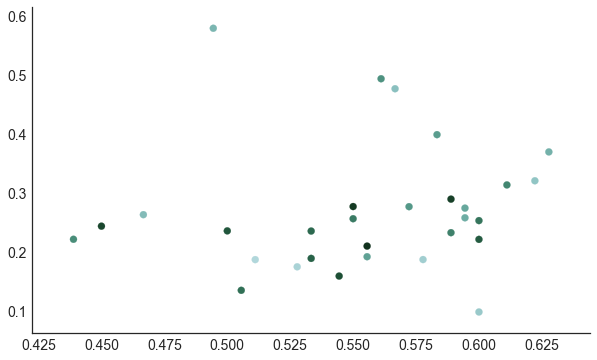

In [166]:
# showing the percentage correct for elo level
fig, axes = plt.subplots(1, 1, figsize=(10,6))

plt.scatter(tur_sub.feedback, tur_sub['feature_drop'],s=50,color=greens)

sns.despine()

In [167]:
for i in range(0,10,1):
    print(list[i]+": "+str(np.corrcoef(tur_sub.delta_c, tur_sub[list[i]])[0,1]))

pruning: 0.301930598946
gamma: -0.332510234139
feature_drop: -0.0761053398833
lapse: 0.099925982061
scaling: 0.0429492121853
center: -0.344796439324
2-conn: -0.330181403267
2-unc: 0.411117357739
3-in-a-row: 0.421307559742
4-in-a-row: 0.133461888948


In [168]:
for i in range(0,10,1):
    print(list[i]+": "+str(sts.spearmanr(tur_sub.delta_c, tur_sub[list[i]])))

pruning: SpearmanrResult(correlation=0.34646195784316197, pvalue=0.060712960876250631)
gamma: SpearmanrResult(correlation=-0.15376057345512198, pvalue=0.41722969090297124)
feature_drop: SpearmanrResult(correlation=-0.0022251891961667441, pvalue=0.99068892349047044)
lapse: SpearmanrResult(correlation=-0.13262127609153793, pvalue=0.48478550710557844)
scaling: SpearmanrResult(correlation=0.059857589376885408, pvalue=0.75336583211557795)
center: SpearmanrResult(correlation=-0.3032932874375272, pvalue=0.10325874788763012)
2-conn: SpearmanrResult(correlation=-0.40498443370234732, pvalue=0.026416625354687921)
2-unc: SpearmanrResult(correlation=0.15309301669627198, pvalue=0.41927915157054851)
3-in-a-row: SpearmanrResult(correlation=0.21651090878702414, pvalue=0.25047999944789279)
4-in-a-row: SpearmanrResult(correlation=0.012461059498533763, pvalue=0.94789191878955126)


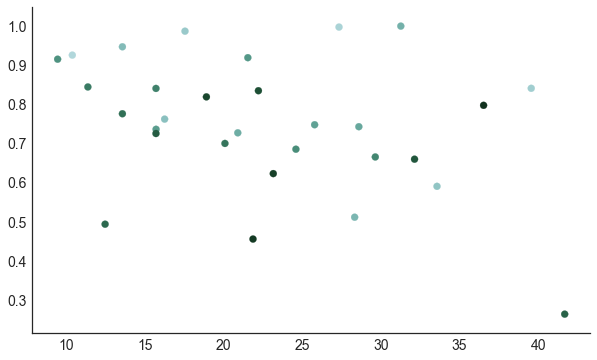

In [169]:
# showing the percentage correct for centering feature
fig, axes = plt.subplots(1, 1, figsize=(10,6))


plt.scatter(tur_sub.delta_c, tur_sub['center'],s=50,color=greens)

'''
plt.setp(
    axes, 
    xlim=[-500,300], xticks=np.arange(-500, 301, 100), xlabel='Elo',
    ylim=[0.40,0.65], yticks=np.arange(0.40, 0.66, 0.05), ylabel='Accuracy'
)
'''

sns.despine()